# Adam
Adam 是一个结合了动量法和 RMSProp 的优化算法，其结合了两者的优点。

## Adam 算法
Adam 算法会使用一个动量变量 v 和一个 RMSProp 中的梯度元素平方的移动指数加权平均 s，首先将他们全部初始化为 0，然后在每次迭代中，计算他们的移动加权平均进行更新

$$
v = \beta_1 v + (1 - \beta_1) g \\
s = \beta_2 s + (1 - \beta_2) g^2
$$

在 adam 算法里，为了减轻 v 和 s 被初始化为 0 的初期对计算指数加权移动平均的影响，每次 v 和 s 都做下面的修正

$$
\hat{v} = \frac{v}{1 - \beta_1^t} \\
\hat{s} = \frac{s}{1 - \beta_2^t}
$$

这里 t 是迭代次数，可以看到，当 $0 \leq \beta_1, \beta_2 \leq 1$ 的时候，迭代到后期 t 比较大，那么 $\beta_1^t$ 和 $\beta_2^t$ 就几乎为 0，就不会对 v 和 s 有任何影响了，算法作者建议$\beta_1 = 0.9$, $\beta_2 = 0.999$。

最后使用修正之后的 $\hat{v}$ 和 $\hat{s}$ 进行学习率的重新计算

$$
g' = \frac{\eta \hat{v}}{\sqrt{\hat{s} + \epsilon}}
$$

这里 $\eta$ 是学习率，$epsilon$ 仍然是为了数值稳定性而添加的常数，最后参数更新有

$$
\theta_i = \theta_{i-1} - g'
$$

下面我们来实现一下 adam 算法

In [1]:
def adam(parameters, vs, sqrs, lr, t, beta1=0.9, beta2=0.999):
    eps = 1e-8
    for param, v, sqr in zip(parameters, vs, sqrs):
        v[:] = beta1 * v + (1 - beta1) * param.grad.data
        sqr[:] = beta2 * sqr + (1 - beta2) * param.grad.data ** 2
        v_hat = v / (1 - beta1 ** t)
        s_hat = sqr / (1 - beta2 ** t)
        param.data = param.data - lr * v_hat / torch.sqrt(s_hat + eps)

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [3]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项和动量项
sqrs = []
vs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    vs.append(torch.zeros_like(param.data))
t = 1
# 开始训练
losses = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        adam(net.parameters(), vs, sqrs, 1e-3, t) # 学习率设为 0.001
        t += 1
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0:
            losses.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.362426
epoch: 1, Train Loss: 0.175529
epoch: 2, Train Loss: 0.125372
epoch: 3, Train Loss: 0.101720
epoch: 4, Train Loss: 0.085235
使用时间: 64.65648 s


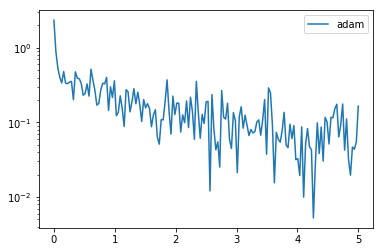

In [4]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='adam')
plt.legend(loc='best')

可以看到使用 adam 算法 loss 能够更快更好地收敛，但是一定要小心学习率的设定，使用自适应的算法一般需要更小的学习率

当然 pytorch 中也内置了 adam 的实现，只需要调用 `torch.optim.Adam()`，下面是例子

In [5]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
# 开始训练
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data[0]
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.360587
epoch: 1, Train Loss: 0.176307
epoch: 2, Train Loss: 0.124479
epoch: 3, Train Loss: 0.100839
epoch: 4, Train Loss: 0.084549
使用时间: 78.84799 s


这是我们讲的最后一个优化算法，下面放一张各个优化算法的对比图结束这一节的内容

![](https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/nn3/opt1.gif)

![](https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/nn3/opt2.gif)

